# A simple, flexible 2D raytracer

This notebook demonstrates the capabilities of the module.

In [1]:
import raytracer as rt
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Walkthrough
Rays are represented as particles, with a position and direction.

The environment is represented by a series of line segments, each defining a boundary between materials with two different refractive indices.

In [3]:
# origin, direction
ray = rt.Ray((0, 2), (1, 1))
# line segments, pairs of refractive indices for each polygon defined in the DXF
env = rt.Environment('floorplan.dxf', [(1.0, 1.4), (1.0, 1.4)], scale=0.0254)

<IPython.core.display.Javascript object>


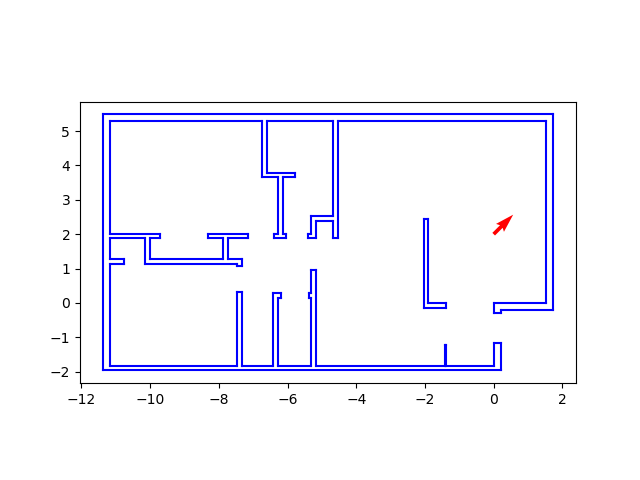

In [4]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

for line_segment in env.obstacles:
    ax.plot(line_segment[:, 0], line_segment[:, 1], c='b')

ax.quiver(ray.origin[0], ray.origin[1], ray.direction[0], ray.direction[1], color='r')

Determine where the ray will intersect with the environment using `Ray.closest_hit`.

In [5]:
distance, boundary = ray.closest_hit(env)
# if distance is not None:

<IPython.core.display.Javascript object>


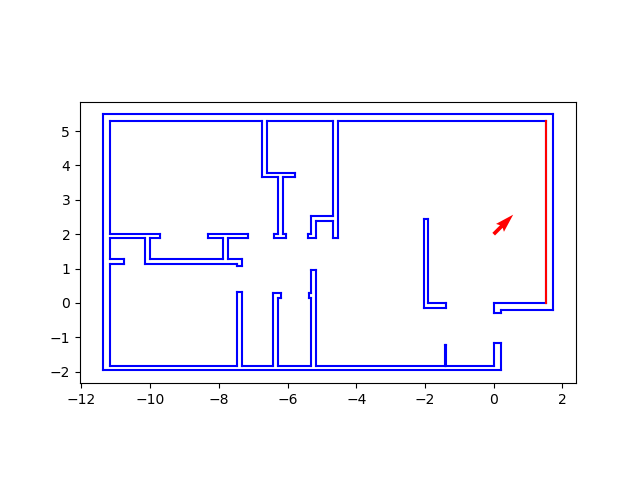

In [6]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

for obstacle in env.obstacles:
    ax.plot(obstacle[:, 0], obstacle[:, 1], c='b')

ax.quiver(ray.origin[0], ray.origin[1], ray.direction[0], ray.direction[1], color='r')
ax.plot(boundary.geometry[:, 0], boundary.geometry[:, 1], c='r')

Then propagate the ray using `Ray.propagate`. This updates the ray's position and time of flight depending on its speed.

Choose how the ray will interact with the boundary using `Ray.reflect` or `Ray.refract`. `Ray.refelect` will always return `True`. `Ray.refract` will return `False` if no refraction is possible (total internal reflection would occur) and `True` otherwise. The ray's direction and speed (for refraction) is updated upon success.

In [7]:
ray.propagate(distance)
ray.refract(boundary)

True

<IPython.core.display.Javascript object>


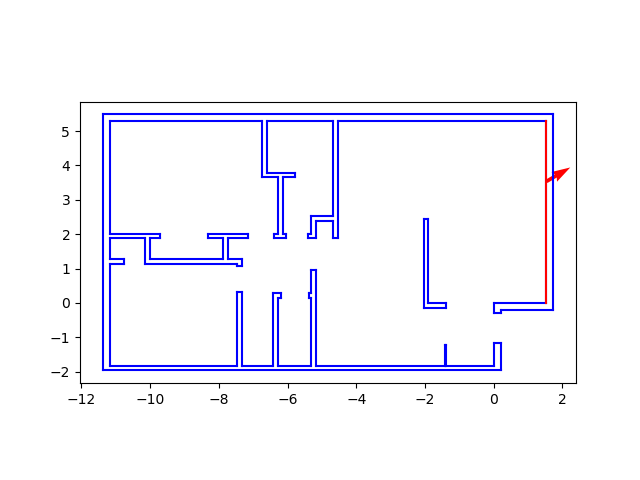

In [8]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

for obstacle in env.obstacles:
    ax.plot(obstacle[:, 0], obstacle[:, 1], c='b')

ax.quiver(ray.origin[0], ray.origin[1], ray.direction[0], ray.direction[1], color='r')
ax.plot(boundary.geometry[:, 0], boundary.geometry[:, 1], c='r')

## Example

This example will trace 3 rays originating at (0, 2) and pointing in random directions to a maximum depth of 5.

In [9]:
import numpy as np
import multiprocessing
import tqdm

In [10]:
MAX_DEPTH = 5
N_RAYS = 3
origin = (0, 2)
rays = [rt.Ray(origin, (np.cos(a), np.sin(a))) for a in 2*np.pi*np.random.rand(N_RAYS)]

The `trace` function will propagate one ray up to a maximum depth and return where it intersected with the environment.

In [11]:
def trace(args):
    ray, env, MAX_DEPTH = args
    depth = 0
    hits = [tuple(ray.origin)] # where the ray intersected the environment
    
    while depth < MAX_DEPTH:
        distance, boundary = ray.closest_hit(env)
        # if the ray intersects with an obstacle
        if boundary is not None:
            ray.propagate(distance)
            hits.append(tuple(ray.origin))
            # randomly select reflection or refraction
            if np.random.rand() < 0.5:
                refracted = ray.refract(boundary)
                # if no refraction is possble, then reflect
                if not refracted:
                    ray.reflect(boundary)
            else:
                ray.reflect(boundary)
        else:
            ray.propagate(5) # propagate a maximum distance
            hits.append(tuple(ray.origin))
            depth = MAX_DEPTH
        
        depth += 1
        
    return hits

In [12]:
pool = multiprocessing.Pool(processes=4)
args = zip(rays, [env]*N_RAYS, [MAX_DEPTH]*N_RAYS)
ray_paths = []
for points in tqdm.tqdm_notebook(pool.imap(trace, args), total=N_RAYS):
    ray_paths.append(points)
pool.close()
pool.join()

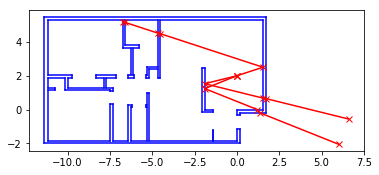

In [12]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

for obstacle in env.obstacles:
    ax.plot(obstacle[:, 0], obstacle[:, 1], c='b')
    
for ray_path in ray_paths:
    ray_x, ray_y = zip(*ray_path)
    ax.plot(ray_x, ray_y, marker='x', c='r')